In [62]:
import numpy as np
import pandas as pd
from math import log
import collections
from collections import Counter
import re
import minisom
from minisom import MiniSom
from sklearn.preprocessing import minmax_scale

In [72]:
data_txt = pd.read_csv('D:/NN HW 2021/HW2/bbc-text.csv')
stop_words = pd.read_csv('D:/NN HW 2021/HW2/stopwords.txt', sep ='\t')
#data_df = pd.DataFrame(data)

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [73]:
x = data_txt.loc[:]['text']
y = data_txt.loc[:]['category']
class_labels = y.unique()
x = [re.sub("[^a-zA-Z ]+", "",txt) for txt in x]
x = [re.sub(r'\b\w{1,2}\b','',txt) for txt in x] 

target = np.zeros(len(y), dtype=int)
y_array = y.to_numpy(y)
target[y_array == 'business'] = 0
target[y_array == 'entertainment'] = 1
target[y_array == 'politics'] = 2
target[y_array == 'sport'] = 3
target[y_array == 'tech'] = 4

In [80]:
stopw_list = list(stop_words.columns)[0].split()
docs_list = list()
docs_list_split = list()
for txt in x:
    txt = txt.split()
    txt_n = ""
    for word in txt:
        if(word in stopw_list) == False:
            txt_n =txt_n+word+" "
    docs_list_split.append(txt_n.split())
    docs_list.append(txt_n)

'future hands viewers home theatre systems plasma highdefinition tvs digital video recorders moving living room way people watch radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talkedabout technologies ces digital personal video recorders dvr pvr settop boxes like tivo sky system allow people record store play pause forward wind programmes want essentially technology allows much personalised also builtin highdefinition sets big business japan slower take europe lack highdefinition programming people forward wind adverts also forget abiding network channel schedules putting together alacarte entertainment networks cable satellite companies worried means terms advertising revenues well brand identity viewer lo

In [6]:
def tfidf(doc, _corpus):
    dic = collections.defaultdict(int)
    for x in _corpus:
        for y in x:
            dic[y] += 1.
    return {x: doc[x] * log(len(_corpus) / dic[x]) for x in doc}
doc_sets = [Counter(doc.split()) for doc in docs_list]
docs_list_tfidf = [tfidf(x, doc_sets) for x in doc_sets]

In [7]:
df_tfidf_docs = pd.DataFrame(docs_list_tfidf)
#print(df_tfidf_docs.head(5))
df_tfidf_docs =  df_tfidf_docs.fillna(0)
data = df_tfidf_docs.to_numpy()
data

array([[ 4.21078675,  6.72741355, 11.15558444, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  7.70751219,
         7.70751219,  0.        ],
       [ 2.10539337,  0.        ,  0.        , ...,  0.        ,
         0.        ,  7.70751219]])

In [8]:
data.shape

(2225, 29985)

In [9]:
for i in range(data.shape[0]):
    temp = data[i]
    data[i] = minmax_scale(temp,feature_range=(0,1))

In [55]:
sample_num, words_num = df_tfidf_docs.shape
som_shape = (5,5)
som = MiniSom(som_shape[0], som_shape[1], words_num, sigma= 3.5, learning_rate=0.25,
              neighborhood_function='gaussian',topology='hexagonal', 
              activation_distance='euclidean')
som.random_weights_init(data)
som.train_batch(data, 5000, verbose=True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 2.405710721127322


<Figure size 432x288 with 0 Axes>

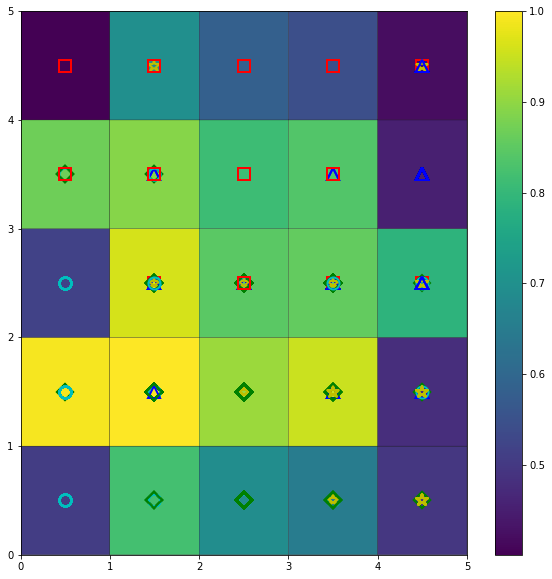

In [56]:
from pylab import plot,axis,show,pcolor,colorbar,bone
import matplotlib.pyplot as plt
bone()
plt.figure(figsize=(10, 10))
pcolor(som.distance_map().T,cmap='viridis' ,edgecolors='k') # distance map as background
colorbar()
markers = ['D','^' ,'o','s', '*' ]
colors = ['g','b','c','r','y']
for cnt,xx in enumerate(data):
  w = som.winner(xx) 
  plot(w[0]+.5,w[1]+.5,markers[target[cnt]],markerfacecolor='None',
       markeredgecolor=colors[target[cnt]],markersize=12,markeredgewidth=2)

show()

In [57]:
winner_coordinates = np.array([som.winner(x) for x in data]).T
frequencies = som.activation_response(data)
print(pd.DataFrame(frequencies))


       0      1      2      3      4
0  100.0   97.0   68.0   43.0  115.0
1   17.0   64.0  127.0  113.0   41.0
2   96.0   70.0  109.0   17.0   86.0
3   15.0  137.0  348.0    6.0   69.0
4   81.0  106.0   88.0   66.0  146.0


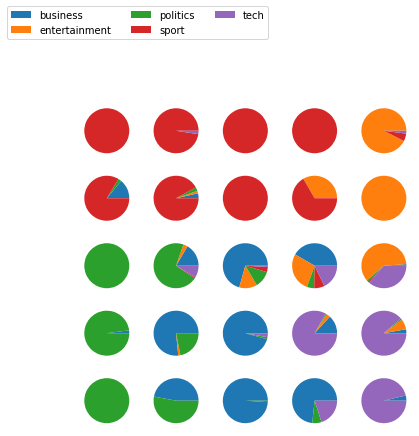

In [58]:
import matplotlib.gridspec as gridspec
label_names = {0:'business',1:'entertainment', 2:'politics', 3:'sport', 4:'tech'}
labels_map = som.labels_map(data, [label_names[t] for t in target])
fig = plt.figure(figsize=(6, 6))
the_grid = gridspec.GridSpec(som_shape[0], som_shape[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[som_shape[0]-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(1,4), ncol=3)
show()

In [59]:
labelmap_df = labels_map.items()
labelmap_df = sorted(labelmap_df)
for neroun , detail in labelmap_df:
    print(neroun ,detail)

(0, 0) Counter({'politics': 100})
(0, 1) Counter({'politics': 95, 'business': 2})
(0, 2) Counter({'politics': 68})
(0, 3) Counter({'sport': 36, 'business': 6, 'politics': 1})
(0, 4) Counter({'sport': 115})
(1, 0) Counter({'politics': 9, 'business': 8})
(1, 1) Counter({'business': 49, 'politics': 14, 'entertainment': 1})
(1, 2) Counter({'politics': 90, 'business': 21, 'tech': 11, 'entertainment': 4, 'sport': 1})
(1, 3) Counter({'sport': 104, 'business': 4, 'politics': 3, 'entertainment': 2})
(1, 4) Counter({'sport': 40, 'tech': 1})
(2, 0) Counter({'business': 95, 'politics': 1})
(2, 1) Counter({'business': 67, 'tech': 2, 'politics': 1})
(2, 2) Counter({'business': 77, 'entertainment': 14, 'politics': 13, 'sport': 4, 'tech': 1})
(2, 3) Counter({'sport': 17})
(2, 4) Counter({'sport': 86})
(3, 0) Counter({'business': 11, 'tech': 3, 'politics': 1})
(3, 1) Counter({'tech': 114, 'business': 18, 'entertainment': 4, 'politics': 1})
(3, 2) Counter({'business': 145, 'entertainment': 97, 'tech': 6

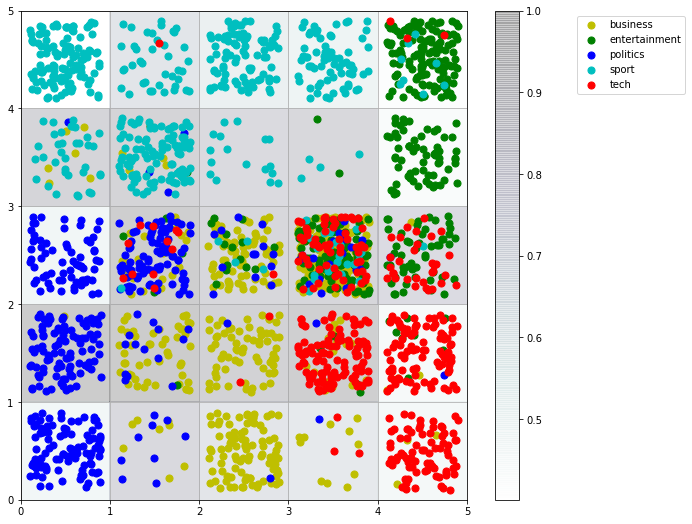

In [60]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(bbox_to_anchor=(1.5,1))
plt.grid()
plt.show()

In [61]:
distance_data =  som._distance_from_weights(data)
dis_data_from_winner = dict()
for count in range (len(data)):
    i, j = winner_coordinates[0][count] , winner_coordinates[1][count]
    dis_tmp = distance_data[count].reshape(som_shape)[i][j]
    dis_data_from_winner[count] = dis_tmp
sum(list(dis_data_from_winner.values()))

5352.7063545083